## Import Important Packages 


In [2]:
import numpy as np 
import os
import cv2
import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import model_from_yaml

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np 
import os
import glob
import cv2
import glob
import itertools
import skimage.io as io
import skimage.transform as trans
from tensorflow.keras.initializers import Constant
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf 



## GPU configuration

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Add the Custom loss functions 

In [4]:
from tensorflow.keras import backend as K

def IoU(y_true, y_pred):
        
    ''' 
    The Intersection over Union (IoU) also referred to as the Jaccard index (JI),
    is essentially a method to quantify the percent overlap between the GT mask
    and prediction output. The IoU metric measures the number of pixels common 
    between the target and prediction masks divided by the total number of pixels
    present across both masks.
  
    Input Arguments: 
        y_true: True Labels of the 2D images so called ground truth (GT).
        y_pred: Predicted Labels of the 2D images so called Predicted/ segmented Mask.
        
    Output Arguments: 

        iou: The IoU between y_true and y_pred

    Author: Md. Kamrul Hasan, 
            Erasmus Scholar on Medical Imaging and Application (MAIA)
            E-mail: kamruleeekuet@gmail.com

    '''
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection) / (K.sum(y_true_f) + K.sum(y_pred_f)-intersection)


def IoU_loss(y_true, y_pred):
    return 1-IoU(y_true, y_pred)


def bce_IoU_loss(y_true, y_pred):
    return (binary_crossentropy(y_true, y_pred) + IoU_loss(y_true, y_pred))


## Model Architecture 

In [5]:
#...................Model............................
def pretrained(nClasses, input_height, input_width):
  img_input = Input(shape=(input_height, input_width, 3)) 

  #...................Feature Generator..............................
  FrG = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding="same")(img_input)
                          
  FrG = BatchNormalization()(FrG)
  
  FrG = SeparableConv2D(filters = 256,
                        kernel_size = (3, 3),
                        activation = 'relu', 
                        kernel_initializer='glorot_uniform', 
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
      
  FrG = SeparableConv2D(filters = 64,
                        kernel_size = (3, 3), 
                        activation = 'relu',
                        kernel_initializer='glorot_uniform',
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
  
  FrG = SeparableConv2D(filters = nClasses,
                        kernel_size = (3, 3), 
                        activation = 'relu',
                        kernel_initializer='glorot_uniform',
                        padding="same")(FrG)
  FrG = BatchNormalization()(FrG)
  print(FrG.shape)
    #........................................................................................................

  vgg_Base = VGG16(weights = 'imagenet',
                    include_top = False,
                    input_tensor = img_input) 
  
  conv_14 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(vgg_Base.output)
  conv_14 = BatchNormalization()(conv_14)


  conv_15 = SeparableConv2D(filters = 1024, 
                            kernel_size = (3, 3), 
                            activation = 'relu', 
                            kernel_initializer='glorot_uniform', 
                            padding="same")(conv_14)
  conv_15 = BatchNormalization()(conv_15)

  
  deconv_1 = UpSampling2D(size = (2, 2))(conv_15)
  deconv_1 = concatenate([vgg_Base.get_layer(name="block4_pool").output,
                          deconv_1], axis=-1)
  deconv_1 = SeparableConv2D(filters = 512, 
                              kernel_size = (3, 3), 
                              activation = 'relu', 
                              kernel_initializer='glorot_uniform', 
                              padding = "same")(deconv_1)
  deconv_1 = BatchNormalization()(deconv_1)


  deconv_2 = UpSampling2D(size = (2, 2))(deconv_1)
  deconv_2 = concatenate([vgg_Base.get_layer(name="block3_pool").output,
                          deconv_2], axis=-1)
  deconv_2 = SeparableConv2D(filters = 256,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(deconv_2)
  deconv_2 = BatchNormalization()(deconv_2)


  deconv_3 = UpSampling2D( size = (2, 2))(deconv_2)
  deconv_3 = concatenate([vgg_Base.get_layer(name="block2_pool").output,
                          deconv_3], axis=-1)
  deconv_3 = SeparableConv2D(filters = 128,
                              kernel_size = (3, 3),
                              activation = 'relu',
                              kernel_initializer='glorot_uniform',
                              padding = "same")(deconv_3)     
  #deconv_3 = BatchNormalization()(deconv_3)

  
  kept = BatchNormalization()(deconv_3)

  tool = UpSampling2D(size = (2, 2))(kept)
  tool = concatenate([vgg_Base.get_layer( name="block1_pool").output, 
                      tool], axis=-1)
  
  tool = SeparableConv2D(filters = 64,
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = UpSampling2D(size = (2, 2))(tool)
  tool = SeparableConv2D(filters = 64, 
                          kernel_size = (3, 3), 
                          activation = 'relu',
                          kernel_initializer='glorot_uniform', 
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = SeparableConv2D(filters = nClasses,
                          kernel_size = (1, 1),
                          activation = 'relu',
                          kernel_initializer='glorot_uniform',
                          padding = "same")(tool)
  tool = BatchNormalization()(tool)

  tool = concatenate([tool, FrG], axis=-1)

  tool = Conv2D(filters = 1,
                kernel_size = 1,
                activation = 'sigmoid',
                name='tool')(tool)

  modeltool = Model(img_input,tool)
  print(modeltool.summary())

  return modeltool
  
model = pretrained(2,192,256)
print(len(model.layers))


(None, 192, 256, 2)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
__________________________________________________________________________

## Train the stage 1 model

In [5]:

def Train():
        
    #....................Training...........................
    from tensorflow.keras.preprocessing.image import ImageDataGenerator


    #..................Data..........................
    pathMaskTraining = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/maskTraining.npy/arr_0.npy'
    pathRawTraining = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/rawTraining.npy/arr_0.npy'
    checkpoint_path = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/CheckPointEdited/Checkpoint'
    modelSavePath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/pretrainedRobotic_editedFinal2.h5'

    
    maskTraining = np.load(pathMaskTraining).astype(np.float64)
    rawTraining =  np.load(pathRawTraining)

    # Split the data (train, validation)
    x_train, x_valid, y_train, y_valid = train_test_split(rawTraining, maskTraining,test_size=0.33, shuffle= True)

    # init model 
    model = pretrained(2,192,256)
    
    optim = Adadelta(learning_rate=0.01)
    
    # Compile 
    history = model.compile(optimizer = optim, loss = bce_IoU_loss, metrics = IoU)
    
    # save the weights
    batch_size = 8
    
#     earlystop = tf.keras.callbacks.EarlyStopping(patience=15,monitor='val_loss', verbose=1)

    cp_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,save_weights_only=True, save_freq = 10*batch_size)
    
    callbacks = [
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,save_best_only=True,save_weights_only=True, save_freq = 'epoch' ),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1, patience=20, mode='min'), ## new_lr = lr * factor # 5
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=40, mode='min', restore_best_weights=True),    
    tf.keras.callbacks.CSVLogger('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/training.csv'),
    tf.keras.callbacks.TensorBoard(log_dir='/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/logs',write_graph=True),
    tf.keras.callbacks.TerminateOnNaN()
]
    
    results = model.fit(x=x_train,y=y_train,validation_data=(x_valid,y_valid),batch_size=batch_size,epochs=100,callbacks=[callbacks])

    # Save the model
    model.save(modelSavePath)

## Run Training

In [6]:
Train()

(None, 192, 256, 2)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
________________________________________________________________________

Epoch 1/100
375/375 [==============================] - 303s 487ms/step - loss: 1.6397 - IoU: 0.0989 - val_loss: 1.6688 - val_IoU: 0.0930
Epoch 2/100
375/375 [==============================] - 114s 303ms/step - loss: 1.3700 - IoU: 0.1780 - val_loss: 1.3408 - val_IoU: 0.1807
Epoch 3/100
375/375 [==============================] - 114s 305ms/step - loss: 1.2977 - IoU: 0.1962 - val_loss: 1.2554 - val_IoU: 0.2051
Epoch 4/100
375/375 [==============================] - 114s 303ms/step - loss: 1.2486 - IoU: 0.2083 - val_loss: 1.2060 - val_IoU: 0.2176
Epoch 5/100
375/375 [==============================] - 113s 303ms/step - loss: 1.2047 - IoU: 0.2192 - val_loss: 1.1635 - val_IoU: 0.2291
Epoch 6/100
375/375 [==============================] - 117s 312ms/step - loss: 1.1587 - IoU: 0.2319 - val_loss: 1.1130 - val_IoU: 0.2439
Epoch 7/100
375/375 [==============================] - 117s 312ms/step - loss: 1.1101 - IoU: 0.2479 - val_loss: 1.0666 - val_IoU: 0.2606
Epoch 8/100
375/375 [====================

375/375 [==============================] - 113s 301ms/step - loss: 0.0841 - IoU: 0.9349 - val_loss: 0.0928 - val_IoU: 0.9300
Epoch 61/100
375/375 [==============================] - 112s 299ms/step - loss: 0.0841 - IoU: 0.9347 - val_loss: 0.0984 - val_IoU: 0.9269
Epoch 62/100
375/375 [==============================] - 113s 301ms/step - loss: 0.0821 - IoU: 0.9366 - val_loss: 0.0907 - val_IoU: 0.9319
Epoch 63/100
375/375 [==============================] - 112s 299ms/step - loss: 0.0795 - IoU: 0.9386 - val_loss: 0.0902 - val_IoU: 0.9316
Epoch 64/100
375/375 [==============================] - 112s 300ms/step - loss: 0.0791 - IoU: 0.9387 - val_loss: 0.0860 - val_IoU: 0.9354
Epoch 65/100
375/375 [==============================] - 112s 300ms/step - loss: 0.0784 - IoU: 0.9393 - val_loss: 0.0857 - val_IoU: 0.9356
Epoch 66/100
375/375 [==============================] - 112s 300ms/step - loss: 0.0778 - IoU: 0.9401 - val_loss: 0.0943 - val_IoU: 0.9290
Epoch 67/100
375/375 [=========================

## Test Model 

In [15]:
# load testing data
gtTestingPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/gtTesting.npy/arr_0.npy'
rawTestingPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Data/NPY/rawTesting.npy/arr_0.npy'
checkpoint_path = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/Checkpoint'
modelPath = '/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/pretrainedRobotic_editedFinal2.h5'

gtTesting = np.load(gtTestingPath).astype(np.float64)
rawTesting =  np.load(rawTestingPath).astype(np.float64)
gtTesting = gtTesting[:4495]

IMG_WIDTH = 256
IMG_HEIGHT = 192

# ............................load model............................................ 
# model = load_model('./Models/pretrainedRobotic3.h5', custom_objects={'bce_IoU_loss': bce_IoU_loss, 'IoU': IoU})

#............................load weights using checkpoints...........................................
# cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=0)

modelOrig = load_model(modelPath, custom_objects={'bce_IoU_loss': bce_IoU_loss, 'IoU': IoU})
optim = Adadelta(learning_rate=0.01)

latest = tf.train.latest_checkpoint(checkpoint_path)
print('\n# Evaluate on test data')
model = pretrained(2,IMG_HEIGHT,IMG_WIDTH)
model.compile(optimizer = optim, loss = bce_IoU_loss, metrics = IoU)
model.load_weights(modelPath)

scores = model.evaluate(rawTesting, gtTesting, batch_size=8)
pred = modelOrig.predict(rawTesting)




# Evaluate on test data
(None, 192, 256, 2)
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 192, 256, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 192, 256, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 96, 128, 64)  0           block1_conv2[0][0]               
_______________________________________________

562/562 [==============================] - 20s 34ms/step - loss: 0.4937 - IoU: 0.7462


## Visualization 

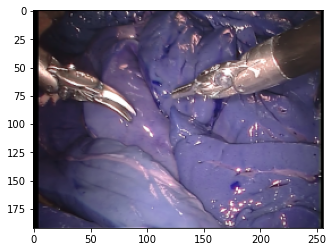

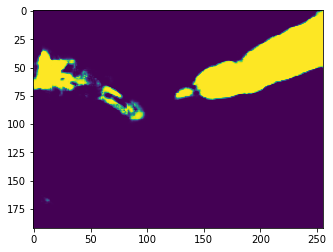

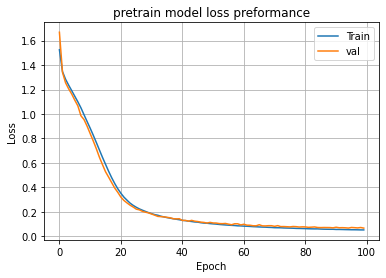

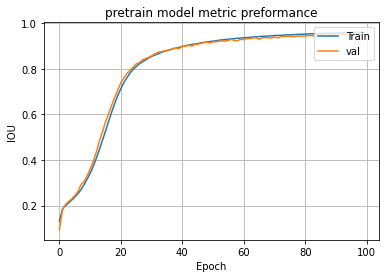

In [16]:
import pandas as pd

plt.imshow(rawTesting[500])
plt.show()
plt.imshow(pred[500])
plt.show()

logs = pd.read_csv('/home/mahmoud/Desktop/laparoscopic-Tools-Segmentation/Models/training.csv')



# # Plot training & validation loss values
plt.figure()
plt.plot(logs['loss'])
plt.plot(logs['val_loss'])
plt.title('pretrain model loss preformance')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper right')
plt.grid('on')
plt.show()

# plot IOU valid and training 
plt.figure()
plt.plot(logs['IoU'])
plt.plot(logs['val_IoU'])
plt.title('pretrain model metric preformance')
plt.ylabel('IOU')
plt.xlabel('Epoch')
plt.legend(['Train','val'], loc='upper right')
plt.grid('on')
plt.show()

In [ ]:
#Plot training & validation loss values
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss Total')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train_total','val_total'], loc='upper right')
plt.grid('on')
plt.show()

